<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/NADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

Cloning into 'nn_hallucinations'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 50 (delta 23), reused 19 (delta 8), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [0]:
import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
import numpy as np
import torch
from torch import distributions 
from torch import nn
from torch import optim
from torch.utils import data
import torchvision
from torchvision import transforms
from torchvision import datasets

In [0]:
def flatten(x):
  return x.view(-1)
  

def binarize(x):
  # TODO(eugenhotaj): Since binarize is called once per epoch, examples will
  # be sampled slightly different each epoch.
  return distributions.Bernoulli(probs=x).sample()

In [4]:
BATCH_SIZE = 512
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    flatten,
    binarize])

train_loader = data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=TRANSFORM),
    batch_size=BATCH_SIZE, 
    shuffle=True)
test_loader = data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,transform=TRANSFORM),
    batch_size=BATCH_SIZE*2)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class NADE(nn.Module):
  """Implementation of the Neural Autoregressive Distribution Estimator (NADE).
  
  Full details available in the paper by Larochelle & Murray (2011).
  """

  def __init__(self, input_dim, hidden_dim):
    """Initializes a new NADE instance.
    
    Args:
      input_dim: The dimension of the input.
      hidden_dim: The dimmension of the hidden layer. NADE only supports one
        hidden layer.
    """
    super().__init__()
    self._input_dim = input_dim
    self._hidden_dim = hidden_dim
    self.params = nn.ParameterDict({
      'in_W': nn.Parameter(torch.zeros(self._hidden_dim, self._input_dim)),
      'in_b': nn.Parameter(torch.zeros(self._hidden_dim,)),
      'h_W': nn.Parameter(torch.zeros(self._input_dim, self._hidden_dim)),
      'h_b': nn.Parameter(torch.zeros(self._input_dim,)),
    })
    nn.init.xavier_normal_(self.params['in_W'])
    nn.init.xavier_normal_(self.params['h_W'])

  # TODO(eugenhotaj): We can probably make training a lot more efficient by 
  # sequentially computing the hidden layer activations then computing the 
  # output layer in parallel. The hidden layer activations must be computed
  # sequentially since the weights are tied between different units which gives
  # NADE the autoregressive property. During inference, we must compute
  # everything sequentially since we need the Model's output from the first 
  # unit to compute the second unit's output and so on.
  def _forward(self, x=None):
    """TODO."""
    in_W, in_b = self.params['in_W'], self.params['in_b']
    h_W, h_b = self.params['h_W'], self.params['h_b']
    batch_size = 1 if x is None else x.shape[0] 

    p_hat = []
    x_hat = []
    a = in_b.expand(batch_size, -1)  # We need one 'a' per batch item.
    for i in range(self._input_dim):
      h = torch.sigmoid(a)
      p_i = torch.sigmoid(h_b[i:i+1] + h @ h_W[i:i+1, :].t())
      p_hat.append(p_i)
      # If no 'x' is given, we must be sampling new values.
      if x is None: 
        x_i = distributions.Bernoulli(probs=p_i).sample()
        x_hat.append(x_i)
      else:
        x_i = x[:, i:i+1]
      a = a + x_i @ in_W[:, i:i+1].t()
    return torch.cat(p_hat, dim=1), torch.cat(x_hat, dim=1) if x_hat else []

  def forward(self, x):
    """Runs forward propagation and returns the probabilities over pixels."""
    return self._forward(x)[0]

  # TODO(eugenhotaj): Extend the sample method to allow for conditional samples.
  # A straightforward way to do this is feed in -1s for the input dims which we
  # want the model to predict. 
  def sample(self):
    """Samples a new image."""
    return self._forward()[1]

In [0]:
def train(model, 
          optimizer, 
          loss_fn, 
          train_loader, 
          eval_loader,
          n_epochs,
          device=torch.device('cpu')):
  model = model.to(device)

  train_losses = []
  eval_losses = []
  for epoch in range(n_epochs):
    model.train()

    train_loss = 0.
    n_examples = 0
    for x, _ in train_loader:
      x = x.to(device)
      n_examples += x.shape[0]
      
      optimizer.zero_grad()
      x_hat = model(x)
      loss = loss_fn(x_hat, x)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * x.shape[0]
    train_loss = train_loss / n_examples
    eval_loss = eval(model, optimizer, loss_fn, eval_loader, device)
    print(f'[{epoch + 1}] train_loss={train_loss} eval_loss={eval_loss}')
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

  return train_losses, eval_losses 

def eval(model, optimizer, loss_fn, eval_loader, device=torch.device('cpu')):
  model = model.to(device)
  model.eval()

  eval_loss = 0.
  n_examples = 0
  with torch.no_grad():
    for x, _ in eval_loader:
      x = x.to(device)
      n_examples += x.shape[0]

      x_hat = model(x)
      loss = loss_fn(x_hat, x)
      eval_loss += loss.item() * x.shape[0]
  return eval_loss / n_examples 

In [14]:
INPUT_SIZE = 784
HIDDEN_SIZE = 500
N_EPOCHS = 50

model = NADE(INPUT_SIZE, HIDDEN_SIZE).to(colab_utils.get_device())
optimizer = optim.Adam(model.parameters())
bce_loss_fn = nn.BCELoss(reduction='none')
loss_fn = lambda y_hat, y: bce_loss_fn(y_hat, y).sum(dim=1).mean()

train_losses, eval_losses = train(model, 
                                  optimizer, 
                                  loss_fn, 
                                  train_loader, 
                                  test_loader, 
                                  N_EPOCHS, 
                                  colab_utils.get_device())

[1] train_loss=204.26982647298178 eval_loss=164.474951953125
[2] train_loss=150.17785798339844 eval_loss=137.37583046875
[3] train_loss=130.8940601969401 eval_loss=123.42357160644531
[4] train_loss=120.1949154296875 eval_loss=115.38952692871094
[5] train_loss=113.62762526855468 eval_loss=109.98153659667969
[6] train_loss=109.15924593098958 eval_loss=106.32349350585937
[7] train_loss=106.00254834798177 eval_loss=103.75104533691406
[8] train_loss=103.7230135579427 eval_loss=101.63451696777344
[9] train_loss=101.84871265462239 eval_loss=100.15334385986328
[10] train_loss=100.4841255859375 eval_loss=98.83680317382813
[11] train_loss=99.28014183756511 eval_loss=97.8914640258789
[12] train_loss=98.27655700683594 eval_loss=97.04755789794922
[13] train_loss=97.43894619547525 eval_loss=96.19424752197266
[14] train_loss=96.6901845743815 eval_loss=95.59015716552734
[15] train_loss=96.02470013834636 eval_loss=94.91009202880859
[16] train_loss=95.46552294921875 eval_loss=94.47946805419922
[17] trai

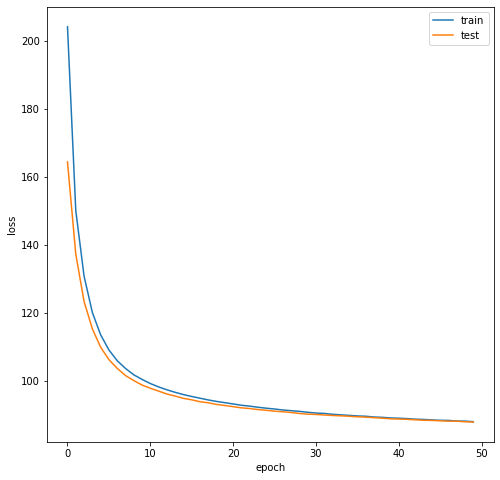

In [28]:
# NOTE(ehotaj): We likely get a lower loss than what's reported in the NADE
# paper because we "re-binarize" the training examples on each epoch. This acts
# as a form of data-augmentation allowing our model to see many more training
# examples.
epochs = len(train_losses)
plt.figure(figsize=(8, 8))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), eval_losses)
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
def show_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img_hat = model(img)
  colab_utils.imshow(img.reshape(28, 28))
  colab_utils.imshow(img_hat.reshape(28, 28))

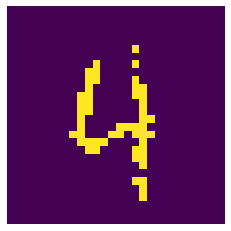

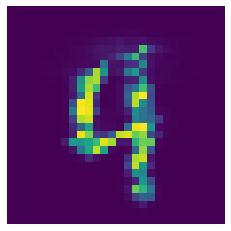

In [61]:
show_random(model, test_loader.dataset)

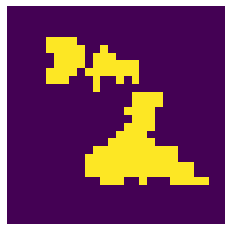

In [65]:
colab_utils.imshow(model.sample().reshape(28, 28))